## **Notebook for analysing nf pipeline output**

### **Packages**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import glob, os, re
import matplotlib.pyplot as plt
from datetime import  datetime
from ipywidgets import widgets, interactive

In [2]:
dt = datetime.today().strftime(format='%d-%m-%Y')

### **Directories & Files**
Uniqueness in directory and file names is assumed for all analyses

The organisation of the `run_dir`: The directory name MUST be unique and reside anywhere inside `sars_dir` directory
 
| Directory name | File name | File source-tool | File description |
| :-------------- | :--------- | :---------------- | :------|
|amplicon|`*.tsv`|Mosdepth|Per-sample amplicon depths<br> ***Cols**:chrom, start, end, region, coverage, sample*
|
|genome|`*.tsv`|Mosdepth|Per-sample genome depths<br> ***Cols**:chrom, start, end, coverage, sample*|
|nextclade|several| Nextclade|All Nextclade outputs|
|pangolin|`*.csv/*.tsv`| Pangolin|Pangolin output in two formats|
|snpEff|`*.vcf.gz`| snpEff|Per-sample unzipped snpEff output|

Additional directories created inside `run_dir`: Used in the analysis

| Directory name | File name | File source-tool | File description |
| :-------------- | :--------- | :---------------- | :------|
|var|`k-per-gene_variant_anns.tsv`|script: `abstract_snpeff_ann_output.py`|Aggregation of individual `snpEff .vcf` outputs by abstracting gene-mutations|
|nxt|`nxt.tsv`|Nextclade|Renamed `Nextclade .tsv` output|
|png|`png.csv`|Pangolin|Renamed `Pangolin .csv` output|


### **Variables**

Reassign accordingly...

In [3]:
seq_name = 'seq21'#seq*
tech = 'MinION'#NextSeq/MiSeq/MinION
seq_dt = '29/10/2021'#DD/MM/YYYY
lib_prep = 'NEBNext'#NEBNext/NEBNext_FS/COVIDSeq/Nextera_XT
primer_set = 'ARTIC_V3'#ARTIC_V3/ARTIC_V4
identifier = 'ONT_seq21' #used in naming file outputs
sars_dir = 'SARS-CoV-2' #name of root directory for all SARS-associated work
run_dir = '2021-10-29_run21_nanopore' #name of the run directory containing viralcon pipeline output as implemented by Kibet
home_dir = os.getenv('HOME') #get OS home directory
parent_dir = glob.glob(f'{home_dir}/**/{sars_dir}', recursive=True)[0]

### **Functions**

In [4]:
# define a func to replace spaces in the header names
def tidy_header(df):
    df.columns = [col.replace(' ', '_') for col in df.columns]
    return df

In [5]:
# define func to retrieve particular columns from a df (spaces in col names must be replaced with _ in the input col_list)
def get_cols(df, col_list):
    new_df = tidy_header(df)
    return new_df[col_list]

In [6]:
# define a function to replace from a dictionary ('key is what is to be replaced': 'value is the replacement')
def replace(string, substitutions):
    substrings = sorted(substitutions, key=len, reverse=True)
    regex = re.compile('|'.join(map(re.escape, substrings)))
    return regex.sub(lambda match: substitutions[match.group(0)], string)

In [7]:
# define function to merge variants and nextclade data
def merge_varNxt(df_var_cln, df_nxt_cln):
    return (df_var_cln.set_index('sample_name').merge(df_nxt_cln
          .set_index('seqName'), how='outer', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'sample_name'}))

In [8]:
# define function to merge pangolin and variants-nextclade data
def merge_pngVxt(df_png_cln, df_varNxt):
    return (df_png_cln.set_index('Sequence_name').merge(df_varNxt
        .set_index('sample_name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'Sequence_name'}))


In [9]:
# define function to merge metadata with cts data
def merge_rmdCts(df_rmd_cln, df_cts_cln):
    return (df_rmd_cln.set_index('S_NUM').merge(df_cts_cln.set_index('Sample_Name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'S_NUM'}))


In [10]:
# define function to merge metadata and seq data
def merge_vnpPmd(df_pngVxt, df_rmdCts):
    return (df_pngVxt.set_index('S_NUM')
            .merge(df_rmdCts.set_index('S_NUM'), how='left', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'S_NUM'}))

In [11]:
# define a function to retrieve MoC and all mutations for the s-gene
def get_mut_of_concern(ann_file_name, moc_list):

    def intersection(x, y):
        return list(set(x) & set(y))

    moc_list = moc_list
#     file_name = 'k-per-gene_variant_anns.tsv'
    df = ann_file_name[['sample_name','S']]

#     df = pd.read_table(f'{base_dir}/{file_name}')[['sample_name','S']]
    mutations = []
    moc = []
    sample_id = []
    for row in df.itertuples():
        if isinstance(row.S, str):
            sgene = row.S
        else: 
            sgene = str(row.S)
        substitutions = sgene.replace(' ', '').split(',')[1:-1]
        if len(moc_list) >= len(intersection(moc_list, substitutions)) > 0:
            intsct = intersection(moc_list, substitutions)
            sample_name = row.sample_name
            mutations.append(str(substitutions).replace("[", "").replace("]", "").replace("'", ""))
            moc.append(str(intsct).replace("[", "").replace("]", "").replace("'", ""))
            sample_id.append(sample_name)
        else: pass 
    df = pd.DataFrame({'Sample_ID': sample_id, 'Mut_of_Concern_(S)': moc, 'All_Mutations_(S)': mutations})
    df_fnl = df.assign(Sample_ID = df['Sample_ID'].apply(lambda x: x.split('_')[0]))
    return df_fnl

In [12]:
def replace_with_who_lin(x):
    if x == 'B.1.1.7':
        return x.replace(x, 'B.1.1.7(Alpha)')
    elif x == 'B.1.617.2':
        return x.replace(x, 'B.1.617.2(Delta)')
    elif x == 'B.1.351':
        return x.replace(x, 'B.1.351(Beta)')
    elif x == 'B.1.525':
        return x.replace(x, 'B.1.525(Eta)')
    elif 'AY' in str(x):
        return str(x).replace(str(x), str(x)+'(Delta)')
    return x
    
    

### **Depth plots**

### **Variants data**

In [14]:
# import the collated file for all the snpEff outputs
df_var = pd.read_csv(glob.glob(f'{parent_dir}/**/{run_dir}/var/k-per-gene_variant_anns.tsv', recursive=True)[0], sep='\t')
df_var_fnl = df_var.assign(sample_name = df_var['sample_name'].apply(lambda x: '_'.join(x.split('_')[:-1]) if (len(x.split('_')) > 2) else x.split('_')[0]))

In [15]:
df_var_fnl.head()

,sample_name,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10
0,COVM01413,31,"G30D, G30D, F924F, A1306S, P2046L, P2287S, D29...",NaN,"T19R, D428D, L452R, T478K, D614G, P681R, D950N,",S26L,NaN,NaN,I82T,NaN,"V82A, T120I",NaN,D119_F120del,"D63G, D377Y",NaN,NaN,NaN
1,COVC24707,41,"F924F, A1306S, F1925F, P2046L, P2287S, M2365I,...",NaN,"T19R, L452R, T478K, L518L, D614G, P681R, D950N...",S26L,NaN,NaN,I82T,NaN,"V82A, T120I",NaN,D119_F120del,"D63G, S193I, R203M, G215C, D377Y",NaN,NaN,NaN
2,COVM01324,42,"G146C, R184H, K261N, F548F, F548F, Q611H, F924...",NaN,"T19R, E156_R158delinsG, L452R, T478K, D614G, P...","S26L, D27H",NaN,NaN,"I82T, Y199Y",NaN,"V82A, T120I",NaN,D119_F120del,"D63G, R203M, G215C, D377Y",NaN,NaN,NaN
3,COVM01366,22,"F924F, T1881I, V3689V, L4715L, A5062A, H5401Y",NaN,"T19R, E156_R158delinsG, L452R, T478K, D614G, P...",S26L,NaN,NaN,I82T,NaN,"V82A, T120I",NaN,D119_F120del,"D63G, R203M, G215C, D377Y",NaN,NaN,NaN
4,COVM01362,34,"F924F, A1306S, P1961P, P2046L, T2068T, P2287S,...",NaN,"T19R, E156_R158delinsG, L452R, T478K, D614G, P...",S26L,NaN,NaN,I82T,NaN,"V82A, T120I",NaN,D119_F120del,"D63G, D377Y",NaN,NaN,NaN


### **Nextclade data**

In [38]:
# import Nextclade clade data
df_nxt = pd.read_table(glob.glob(f'{parent_dir}/**/{run_dir}/nxt/nxt.tsv', recursive=True)[0])

# retrieve cols seqName and clade (func get_cols replaces col name spaces with _)
cols = ['seqName', 'clade', 'totalMissing']
df_nxt_cln = get_cols(df_nxt, cols)
coverage = round(100 - (df_nxt_cln['totalMissing'] / 29903) * 100, 1)
if tech == 'MinION':
    df_nxt_cln1 = df_nxt_cln.assign(seqName = df_nxt_cln['seqName'].apply(lambda x: '_'.join((x.split('.')[0]).split('_')[1:-1]) if (len(x.split('_')) > 2) else (x.split('/')[0])))
else:
    df_nxt_cln1 = df_nxt_cln.assign(seqName = df_nxt_cln['seqName'].apply(lambda x: '_'.join((x.split('.')[0]).split('_')[1:-1]) if (len(x.split('_')) > 2) else (x.split('_')[0])))
df_nxt_cln2 = df_nxt_cln1.assign(coverage = coverage).drop('totalMissing', axis=1)
df_nxt_fnl = df_nxt_cln2#.assign(tech=tech)

In [39]:
df_nxt_fnl.tail()

,seqName,clade,coverage
91,COVM01413,21J (Delta),83.3
92,COVM01415,"20I (Alpha, V1)",55.2
93,COVM01417,21A (Delta),96.0
94,COVM01412,"20I (Alpha, V1)",98.9
95,COVM01416,"20I (Alpha, V1)",98.0


### **Pangolin data Ran: 27-10-2021**

In [40]:
# import Pangolin lineage data
df_png = pd.read_csv(glob.glob(f'{parent_dir}/**/{run_dir}/png/png.csv', recursive=True)[0])
# base_dir_pango = '/home/ouso/nextclade_files/batch2/nextclade_files_04-04-2021_11:25'
# file_name_pango = 'consensus_pango.xlsx'

# df_png = pd.read_excel(f'{base_dir_pango}/{file_name_pango}')
months = {'January': 'Jan', 'February': 'Feb', 'March': 'Mar',
         'April': 'Apr', 'June': 'Jun', 'July': 'Jul', 'August': 'Aug',
          'September': 'Sep', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec'}
# retrieve cols Sequence_name and Lineage (func get_cols replaces col names spaces with _)
cols = ['Sequence_name', 'Lineage', 'Scorpio_call']#, 'Most_common_countries']
df_png_cln = get_cols(tidy_header(df_png), cols)
df_png_fnl = df_png_cln.assign(Sequence_name = df_png_cln['Sequence_name'].apply(lambda x: '_'.join(x.split('_')[:-1]) if (len(x.split('_')) > 2) else x.split('_')[0]))
# df_png_fnl = df_png_cln1.assign(Date_range=df_png_cln1['Date_range'].apply(lambda x: replace(x, months) if (isinstance(x, str)) else x))

In [41]:
df_png_fnl.head()

,Sequence_name,Lineage,Scorpio_call
0,COVC24700,AY.5,Delta (B.1.617.2-like)
1,COVC24702,AY.41,Delta (B.1.617.2-like)
2,COVC24703,AY.41,Delta (B.1.617.2-like)
3,COVC24704,AY.5,Delta (B.1.617.2-like)
4,COVC24705,AY.16,Delta (B.1.617.2-like)


### **Metadata**

In [42]:
# import raw metadata file
df_rmd_cln = pd.read_excel(glob.glob(f'{parent_dir}/**/Outputs/COVID19-resultsCts-merged-cln.xlsx', recursive=True)[0])

In [43]:
df_rmd_cln.head()

,S_NUM,CASE_ID,AGE_YRS,GEND,OCCU,NAT,COUNT_RES,S_COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,DT_SAM_COLL,DT_SAM_RECEP,RESULT,DT_CONF,Well_Position,AVG_Ct,Dt_Run
0,A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT,D01,34.4,2021-06-30 18:48:52
1,C3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaT,D03,35.0,2021-06-30 18:48:52
2,COVC00001,NaN,35.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02,NaN,NaN,NaT
3,COVC00002,NaN,29.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02,NaN,NaN,NaT
4,COVC00003,NaN,50.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaT,NaT,Negative,2020-06-02,NaN,NaN,NaT


### **Combining data**

#### *Merge Variants and Nextclade data*

In [44]:
# merge the nextclade data to the pangolin data
df_varNxt = merge_varNxt(df_var_fnl, df_nxt_fnl)

In [45]:
df_varNxt.head()

,sample_name,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,coverage
0,COVC24700,40,"K261N, K510K, F548F, F548F, F924F, A1306S, C18...",NaN,"T19R, L452R, T478K, D614G, P681R, D950N,",S26L,NaN,NaN,I82T,NaN,"V82A, T120I",NaN,D119_F120del,"D63G, D377Y",NaN,NaN,NaN,21J (Delta),93.2
1,COVC24701,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19A,3.5
2,COVC24702,40,"K261N, K510K, F548F, F548F, F924F, A1306S, C18...",NaN,"T19R, L452R, T478K, D614G, P681R, D950N,",S26L,NaN,NaN,I82T,NaN,"V82A, T120I",NaN,D119_F120del,"D63G, R203M, G215C",NaN,NaN,NaN,21J (Delta),94.5
3,COVC24703,36,"K261N, K510K, F548F, F548F, F924F, A1306S, C18...",NaN,"D614G, P681R,",S26L,NaN,NaN,I82T,NaN,NaN,NaN,D119_F120del,"D63G, R203M, G215C",NaN,NaN,NaN,21J (Delta),81.8
4,COVC24704,40,"K261N, K510K, F548F, F548F, F924F, A1306S, C18...",NaN,"T19R, L452R, T478K, D614G, P681R, D950N,",S26L,NaN,NaN,I82T,NaN,"V82A, T120I",NaN,D119_F120del,"D63G, D377Y",NaN,NaN,NaN,21J (Delta),95.1


#### *Merge pango and var-nextclade data*

In [46]:
# merge the variants-nextclade data to the pangolin data (prioritise pango - left join)
df_pngVxt = merge_pngVxt(df_png_fnl, df_varNxt)

In [47]:
df_pngVxt.head()

,Sequence_name,Lineage,Scorpio_call,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,...,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,coverage
0,COVC24700,AY.5,Delta (B.1.617.2-like),40,"K261N, K510K, F548F, F548F, F924F, A1306S, C18...",NaN,"T19R, L452R, T478K, D614G, P681R, D950N,",S26L,NaN,NaN,...,NaN,"V82A, T120I",NaN,D119_F120del,"D63G, D377Y",NaN,NaN,NaN,21J (Delta),93.2
1,COVC24701,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19A,3.5
2,COVC24702,AY.41,Delta (B.1.617.2-like),40,"K261N, K510K, F548F, F548F, F924F, A1306S, C18...",NaN,"T19R, L452R, T478K, D614G, P681R, D950N,",S26L,NaN,NaN,...,NaN,"V82A, T120I",NaN,D119_F120del,"D63G, R203M, G215C",NaN,NaN,NaN,21J (Delta),94.5
3,COVC24703,AY.41,Delta (B.1.617.2-like),36,"K261N, K510K, F548F, F548F, F924F, A1306S, C18...",NaN,"D614G, P681R,",S26L,NaN,NaN,...,NaN,NaN,NaN,D119_F120del,"D63G, R203M, G215C",NaN,NaN,NaN,21J (Delta),81.8
4,COVC24704,AY.5,Delta (B.1.617.2-like),40,"K261N, K510K, F548F, F548F, F924F, A1306S, C18...",NaN,"T19R, L452R, T478K, D614G, P681R, D950N,",S26L,NaN,NaN,...,NaN,"V82A, T120I",NaN,D119_F120del,"D63G, D377Y",NaN,NaN,NaN,21J (Delta),95.1


In [48]:
df_pngVxt.columns

Index(['Sequence_name', 'Lineage', 'Scorpio_call', 'num_vars', 'ORF1ab',
       'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b',
       'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'clade', 'coverage'],
      dtype='object')

In [49]:
df_pngVxt_cols_rename = ['S_NUM', 'LIN', 'SCORP_CALL',
       'N_VAR', 'ORF1ab', 'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6',
       'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'CLADE',
       'G_COV']
df_pngVxt.columns = df_pngVxt_cols_rename

#### *Merge sequence/var-nxt-png (pngVxt) and  metadata (df_rmd_cln)*

In [50]:
# merge metadata with seq data
df_vnpPmd = merge_vnpPmd(df_pngVxt, df_rmd_cln)

### **QC whether all samples sequenced had metadata**

In [51]:
codes_fnl = set(df_vnpPmd['S_NUM'])
codes_metadata = set(df_rmd_cln['S_NUM'])
codes_union = codes_fnl & codes_metadata
if codes_fnl - codes_union == {}:
    print('All the samples in the the analysis were in the pre-seq metadata')
else:
    print(f'The following samples may be lacking pre-seq metadata, please verify:\n{codes_fnl - codes_union}')
    

The following samples may be lacking pre-seq metadata, please verify:
set()


### **Re-order df_vnpPmd columns and export merged metadata and sequencing data**

In [52]:
header_MS = ['CASE_ID', 'S_NUM', 'AGE_YRS', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct', 'LIN', 'SCORP_CALL', 'CLADE', 'G_COV', 'N_VAR',
               'S', 'ORF1ab', 'ORF1a', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 
               'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10']

In [53]:
header_policy = ['CASE_ID', 'S_NUM', 'AGE_YRS', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct']

In [54]:
#export limited metadata
df_vnpPmd_fnl1 = df_vnpPmd[header_policy].sort_values('S_NUM').drop_duplicates('S_NUM')
df_vnpPmd_fnl1[['SEQ#', 'SEQ_MCHN', 'DT_SEQ', 'LIB_KIT', 'PRM_SET']] = [seq_name, tech, seq_dt, lib_prep, primer_set]
(df_vnpPmd_fnl1
.to_excel(f"{glob.glob(f'{parent_dir}/**/KnowledgeBrief', recursive=True)[0]}/policy-brief-M-{identifier}_{dt}.xlsx"
                     , index=False, na_rep='N/A', float_format='%.1f'))

In [55]:
#export full metadata
df_vnpPmd_fnl = df_vnpPmd[header_MS].sort_values('S_NUM').drop_duplicates('S_NUM')
df_vnpPmd_fnl[['SEQ#', 'SEQ_MCHN', 'DT_SEQ', 'LIB_KIT', 'PRM_SET']] = [seq_name, tech, seq_dt, lib_prep, primer_set]
(df_vnpPmd_fnl
.to_excel(f"{glob.glob(f'{parent_dir}/**/KnowledgeBrief', recursive=True)[0]}/metadata-seq-MS-{identifier}_{dt}.xlsx"
                     , index=False, na_rep='NA', float_format='%.1f'))
# df_vnpPmd_fnl.head()

In [56]:
df_vnpPmd_fnl.head()

,CASE_ID,S_NUM,AGE_YRS,GEND,OCCU,NAT,COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,...,ORF8,N,ORF9a,ORF9b,ORF10,SEQ#,SEQ_MCHN,DT_SEQ,LIB_KIT,PRM_SET
0,MCRH/MIG/19012,COVC24700,22.0,M,NaN,Kenya,Migori,No,NaN,NaN,...,D119_F120del,"D63G, D377Y",NaN,NaN,NaN,seq21,MinION,29/10/2021,NEBNext,ARTIC_V3
1,MCRH/MIG/19013,COVC24701,11.0,M,NaN,Kenya,Migori,No,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,seq21,MinION,29/10/2021,NEBNext,ARTIC_V3
2,MCRH/MIG/19014,COVC24702,22.0,M,NaN,Kenya,Migori,No,NaN,NaN,...,D119_F120del,"D63G, R203M, G215C",NaN,NaN,NaN,seq21,MinION,29/10/2021,NEBNext,ARTIC_V3
3,MCRH/MIG/19015,COVC24703,40.0,M,NaN,Kenya,Migori,No,NaN,NaN,...,D119_F120del,"D63G, R203M, G215C",NaN,NaN,NaN,seq21,MinION,29/10/2021,NEBNext,ARTIC_V3
4,MCRH/MIG/19017,COVC24704,22.0,M,NaN,Kenya,Migori,No,NaN,NaN,...,D119_F120del,"D63G, D377Y",NaN,NaN,NaN,seq21,MinION,29/10/2021,NEBNext,ARTIC_V3


### **County feedback data**

In [57]:
df_raw_meta = df_vnpPmd_fnl[['CASE_ID', 'S_NUM']]
df_caseidSeq = df_raw_meta.merge(df_vnpPmd_fnl, how='right', left_on='S_NUM', right_on='S_NUM')#.drop('SUM_Y', axis=1)

In [58]:
df_vnpPmd_fnl.columns

Index(['CASE_ID', 'S_NUM', 'AGE_YRS', 'GEND', 'OCCU', 'NAT', 'COUNT_RES',
       'TRAV_HIST', 'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL',
       'DT_SAM_RECEP', 'RESULT', 'DT_CONF', 'AVG_Ct', 'LIN', 'SCORP_CALL',
       'CLADE', 'G_COV', 'N_VAR', 'S', 'ORF1ab', 'ORF1a', 'ORF3a', 'ORF3b',
       'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b',
       'ORF10', 'SEQ#', 'SEQ_MCHN', 'DT_SEQ', 'LIB_KIT', 'PRM_SET'],
      dtype='object')

In [61]:
reports = [('Homabay', 'HBCTRH'), ('Migori', 'MCRH'), ('Kisii', 'KCRH'), 
           ('Nyamira', 'NCRH'), ('Siaya', 'SCRH'), ('KCSS')]

for report in reports:
    mask1 = df_vnpPmd_fnl['COUNT_RES'] == report[0]
    mask2 = df_vnpPmd_fnl['CASE_ID'].str.contains(report[1]) == True
    mask3 = df_vnpPmd_fnl['CASE_ID'].str.contains(report[0]) == True
    if len(report) != 2:
        df_report = df_vnpPmd_fnl[mask3 == True]
    else:
        df_report = df_vnpPmd_fnl[mask2 == True]
    if df_report.shape[0] > 0:
        df_report.to_excel(f"{glob.glob(f'{parent_dir}/CountyFeedbacks')[0]}/{seq_name}-results-{report[0]}_{dt}.xlsx", index=False, float_format='%.1f')
    

### **CDC VoI**

In [62]:
gamma = ['L18F', 'T20N', 'P26S', 'D138Y', 'R190S', 'K417T', 'E484K', 'N501Y', 'D614G', 'H655Y', 'T1027I']
delta = ['T19R', '(V70F*)', 'T95I', 'G142D', 'E156-', 'F157-', 'R158G', '(A222V*)', '(W258L*)', '(K417N*)', 
         'L452R', 'T478K', 'D614G', 'P681R', 'D950N']
beta = ['D80A', 'D215G', '241del', '242del', '243del', 'K417N', 'E484K', 'N501Y', 'D614G', 'A701V']
alpha = ['69del', '70del', '144del', '(E484K*)', '(S494P*)', 'N501Y', 'A570D', 'D614G', 'P681H', 'T716I', 'S982A', 'D1118H', '(K1191N*)']

### **CDC VoC**

In [63]:
B16173 = ['T19R', 'G142D', 'L452R', 'E484Q', 'D614G', 'P681R', 'D950N']
kappa = ['(T95I)', 'G142D', 'E154K', 'L452R', 'E484Q', 'D614G', 'P681R', 'Q1071H']
iota = ['L5F', '(D80G*)', 'T95I', '(Y144-*)', '(F157S*)', 'D253G', '(L452R*)', '(S477N*)', 
        'E484K', 'D614G', 'A701V', '(T859N*)', '(D950H*)', '(Q957R*)']
eta = ['A67V', '69del', '70del', '144del', 'E484K', 'D614G', 'Q677H', 'F888L']

In [64]:
x = (set(gamma).union(set(delta)).union(set(beta)).union(set(alpha))).union(set(B16173).union(set(kappa)).union(set(iota)).union(set(eta)))
# x

### **Variants of Concern or under investigation**
 - N501Y (B.1.1.7): UK variant (Alpha)
 - N501Y, E484K, *K417N (B.1.351): SA variant (Beta)
 - N501Y, E484K (P.1): Brazilian variant (Gamma)
 - P681R, E484Q, L452R (B.1.617.2): *Indian variant (Delta)
 - F157L, V367F, Q613H, P681R (A23.1): Ugandan
 - E484K, Q677H, F888L (B.1.525): Multiple (Eta)
 - L5F, T95I, D253G, A701V (B.1.526): USA (Iota)
 - G142D, E154K, Q1071H ('B.1.617.1'): Indian (Kappa)

In [65]:
# MOH mutations of concern (spike only)
moc_list = ['N501Y', 'E484K', 'K417N', 'P681R', 'E484Q', 'L452R', 'A570D', 'D80A', 'Q677H', 'F888L', 'L5F', 'D253G', 'E154K', 'A67V']
file_name = df_var_fnl
df_moc = get_mut_of_concern(file_name, moc_list)

In [66]:
df_moc.head()

,Sample_ID,Mut_of_Concern_(S),All_Mutations_(S)
0,COVM01413,"L452R, P681R","D428D, L452R, T478K, D614G, P681R, D950N"
1,COVC24707,"L452R, P681R","L452R, T478K, L518L, D614G, P681R, D950N,"
2,COVM01324,"L452R, P681R","E156_R158delinsG, L452R, T478K, D614G, P681R, ..."
3,COVM01366,"L452R, P681R","E156_R158delinsG, L452R, T478K, D614G, P681R, ..."
4,COVM01362,"L452R, P681R","E156_R158delinsG, L452R, T478K, D614G, P681R, ..."


### **Subsample brief data**

In [67]:
#reorder columns and shrink data
cols = ['S_NUM', 'G_COV', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'LIN', 'CLADE', 'SCORP_CALL', 'COUNT_RES'
        , 'GEND', 'NAT']

In [68]:
#filter reporting coverage (>=70)
df_brief = df_vnpPmd[cols][df_vnpPmd[cols]['G_COV'] >= 70]

In [69]:
df_brief.head()

,S_NUM,G_COV,DT_SAM_COLL,DT_SAM_RECEP,LIN,CLADE,SCORP_CALL,COUNT_RES,GEND,NAT
0,COVC24700,93.2,2021-10-04,2021-10-08,AY.5,21J (Delta),Delta (B.1.617.2-like),Migori,M,Kenya
2,COVC24702,94.5,2021-10-04,2021-10-08,AY.41,21J (Delta),Delta (B.1.617.2-like),Migori,M,Kenya
3,COVC24703,81.8,2021-10-05,2021-10-08,AY.41,21J (Delta),Delta (B.1.617.2-like),Migori,M,Kenya
4,COVC24704,95.1,2021-10-05,2021-10-08,AY.5,21J (Delta),Delta (B.1.617.2-like),Migori,M,Kenya
5,COVC24705,92.7,2021-10-05,2021-10-08,AY.16,21A (Delta),Delta (B.1.617.2-like),Migori,M,Kenya


### **Merge df_brief with df_moc**

In [70]:
df_brfMoc = (df_brief.merge(df_moc, how='left', left_on='S_NUM', right_on='Sample_ID'))
df_brfMoc_fnl = (df_brfMoc.fillna('N/A')
                 .loc[df_brfMoc['S_NUM'] != 'Undetermined']# removes "undetermined"
                 .drop(['Sample_ID', 'All_Mutations_(S)'], axis=1)
                 .drop_duplicates('S_NUM', ignore_index=True))

### **Policy brief report**

In [71]:
#rename columns
cols = ['Sequence Name', 'Coverage', 'Date Collection (dd-mm-yyyy)', 'Date Received (dd-mm-yyyy)', 'Pango Lineage Annotation', 'Next Clade Lineage Annotation', 'WHO Annotation','Sample County of Origin', 'Gender', 'Subject Country of Origin', 'MoC-S-Protein']
df_brfMoc_fnl.columns = cols

In [72]:
df_brfMoc_fnl.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC24700,93.2,2021-10-04 00:00:00,2021-10-08,AY.5,21J (Delta),Delta (B.1.617.2-like),Migori,M,Kenya,"L452R, P681R"
1,COVC24702,94.5,2021-10-04 00:00:00,2021-10-08,AY.41,21J (Delta),Delta (B.1.617.2-like),Migori,M,Kenya,"L452R, P681R"
2,COVC24703,81.8,2021-10-05 00:00:00,2021-10-08,AY.41,21J (Delta),Delta (B.1.617.2-like),Migori,M,Kenya,P681R
3,COVC24704,95.1,2021-10-05 00:00:00,2021-10-08,AY.5,21J (Delta),Delta (B.1.617.2-like),Migori,M,Kenya,"L452R, P681R"
4,COVC24705,92.7,2021-10-05 00:00:00,2021-10-08,AY.16,21A (Delta),Delta (B.1.617.2-like),Migori,M,Kenya,"L452R, P681R"


### **Reformat dates for KB**

In [73]:
def format_dates(x):
    if isinstance(x, pd.Timestamp):
        return x#x = x.strftime(format='%d-%m-%Y')
    return x
    

In [74]:
df_brfMoc_fnl['Date Collection (dd-mm-yyyy)'] = (df_brfMoc_fnl['Date Collection (dd-mm-yyyy)']
                                                 .map(lambda x: pd.NaT if (x == 'Nil') else format_dates(pd
                                                      .to_datetime(x, errors='coerce', dayfirst=True))))

In [75]:
df_brfMoc_fnl['Date Received (dd-mm-yyyy)'] = (df_brfMoc_fnl['Date Received (dd-mm-yyyy)']
                                                 .map(lambda x: pd.NaT if (x == 'Nil') else format_dates(pd
                                                      .to_datetime(x, errors='coerce', dayfirst=True))))

In [76]:
df_report_fnl = df_brfMoc_fnl

In [77]:
df_report_fnl.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC24700,93.2,2021-10-04,2021-10-08,AY.5,21J (Delta),Delta (B.1.617.2-like),Migori,M,Kenya,"L452R, P681R"
1,COVC24702,94.5,2021-10-04,2021-10-08,AY.41,21J (Delta),Delta (B.1.617.2-like),Migori,M,Kenya,"L452R, P681R"
2,COVC24703,81.8,2021-10-05,2021-10-08,AY.41,21J (Delta),Delta (B.1.617.2-like),Migori,M,Kenya,P681R
3,COVC24704,95.1,2021-10-05,2021-10-08,AY.5,21J (Delta),Delta (B.1.617.2-like),Migori,M,Kenya,"L452R, P681R"
4,COVC24705,92.7,2021-10-05,2021-10-08,AY.16,21A (Delta),Delta (B.1.617.2-like),Migori,M,Kenya,"L452R, P681R"


In [78]:
df_report_fnl.to_excel(f"{glob.glob(f'{parent_dir}/**/KnowledgeBrief', recursive=True)[0]}/policy-brief-T-{identifier}_{dt}.xlsx"
                     , index=False, na_rep='N/A', float_format='%.1f')

In [79]:
(df_report_fnl['Sample County of Origin']
 .value_counts())

Nairobi    74
Migori      9
Kiambu      2
Nyamira     2
Unknown     1
Name: Sample County of Origin, dtype: int64

### **Visualisation**

In [80]:
clr_code = {'TBA48': ('lime', '#00FF00'),
 'TBA01': ('gray', '#808080'),
 'TBA02': ('orangered', '#FF4500'),
 'TBA03': ('cyan', '#00FFFF'),
 'TBA05': ('chocolate', '#D2691E'),
 'TBA07': ('teal', '#008080'),
 'TBA09': ('slategray', '#708090'),
 'TBA11': ('orange', '#FFA500'),
 'TBA13': ('seagreen', '#2E8B57'),
 'TBA15': ('olive', '#808000'),
 'TBA17': ('honeydew', '#FFD700'),
 'TBA19': ('gold', '#8FBC8F'),
 'TBA24': ('aquamarine', '#006400'),
 'TBA25': ('yellowgreen', '#9ACD32'),
 'TBA26': ('tan', '#D2B48C'),
 'TBA27': ('indigo', '#4B0082'),
 'TBA28': ('mediumpurple', '#9370DB'),
 'TBA29': ('blue', '#0000FF'),
 'TBA30': ('darkslateblue', '#483D8B'),
 'TBA31': ('sienna', '#A0522D'),#'TBA32': ('darkkhaki', '#BDB76B'),
 'TBA33': ('khaki', '#F0E68C'),
 'TBA34': ('dodgerblue', '#1E90FF'),
 'TBA35': ('palevioletred', '#DB7093'),
 'TBA36': ('yellow', '#FFFF00'),
 'TBA37': ('floralwhite', '#6495ED'),
 'TBA38': ('green', '#008000'),
 'TBA39': ('red', '#AFEEEE'),
 'TBA40': ('purple', '#800080'),
 'TBA41': ('brown', '#A52A2A'),
 'TBA42': ('chocolate', '#D2691E'),
 'TBA43': ('steelblue', '#4682B4'),
 'TBA44': ('magenta', '#FF00FF'),
 'TBA45': ('rosybrown', '#BC8F8F'),
 'TBA46': ('goldenrod', '#DAA520'),
 'TBA47': ('paleturquoise', '#FF0000'),
 'TBA10': ('lavender', '#E6E6FA'),
 'TBA12': ('pink', '#FFC0CB'),
 'TBA14': ('seashell', '#FFFAF0'),
 'TBA16': ('mediumvioletred', '#C71585'),
 'TBA18': ('black', '#000000'),#'TBA2': ('cornflowerblue', '#FFF5EE'),
 'TBA20': ('saddlebrown', '#8B4513'),
 'TBA21': ('wheat', '#F5DEB3'),
 'TBA22': ('slategray', '#708090'),
 'TBA23': ('silver', '#C0C0C0'),
 'TBA04': ('midnightblue', '#191970'),
 'TBA06': ('darkgreen', '#7FFFD4'),
 'TBA08': ('darkseagreen', '#F0FFF0')}#BLUES NEXT B.1.361
avail_clr = list(clr_code.keys())

In [81]:
grpby_lins = (df_report_fnl.groupby('Pango Lineage Annotation')
        .count().sort_values('coverage', ascending=False))

In [82]:
max_count = grpby_lins['Sequence Name'].max()

In [83]:
max_count

34

In [84]:
clr_code_keys = list(clr_code.keys())

In [85]:
lins = list(grpby_lins.index)

In [86]:
lin_tba =  set(lins) - set(clr_code_keys)
lin_tba

{'AY.13',
 'AY.16',
 'AY.23',
 'AY.33',
 'AY.39.1',
 'AY.41',
 'AY.5',
 'B.1.1.318',
 'B.1.1.7',
 'B.1.617.2'}

In [87]:
print(f'length of lins to be assigned: {len(lin_tba)}')
print(f'length of colours available: {len(avail_clr)}')

length of lins to be assigned: 10
length of colours available: 47


In [88]:
lin_clrs = {}
for z in zip(lins, avail_clr):
#     print(z)
    lin_clrs[z[0]] = clr_code[z[1]][1]
#     clr_code.pop(z[1])
#     avail_clr.remove(z[1])
# lin_clrs

In [89]:
import pprint
# pprint.pprint(clr_code)
# pprint.pprint(avail_clr)
pprint.pprint(lin_clrs)

{'AY.13': '#D2691E',
 'AY.16': '#808080',
 'AY.23': '#008080',
 'AY.33': '#00FFFF',
 'AY.39.1': '#2E8B57',
 'AY.41': '#708090',
 'AY.5': '#FF4500',
 'B.1.1.318': '#808000',
 'B.1.1.7': '#FFA500',
 'B.1.617.2': '#00FF00'}


In [90]:
xlabels = list(map(replace_with_who_lin,list(grpby_lins.sort_index().index)))

In [91]:
lins = (df_report_fnl.groupby('Pango Lineage Annotation').count()
 .coverage.sort_index())

In [92]:
lins.index=xlabels

In [93]:
lins.sort_values(ascending=False)

B.1.617.2(Delta)    34
AY.16(Delta)        25
AY.5(Delta)         16
AY.33(Delta)         3
AY.13(Delta)         2
AY.23(Delta)         2
AY.41(Delta)         2
B.1.1.7(Alpha)       2
AY.39.1(Delta)       1
B.1.1.318            1
Name: coverage, dtype: int64

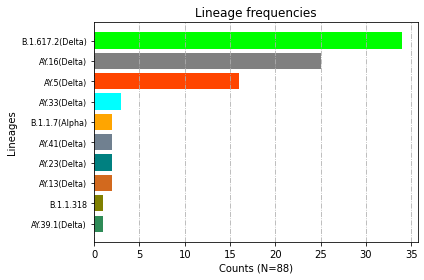

In [94]:
import math
# plot lineage frequencies
width = lins.sort_values(ascending=True)

colors = [lin_clrs[lin.split('(')[0]] for lin in list(width.index)]
# colors = [clr[1] for clr in clr_code.values()]
n = lins.sum()
xticks = np.arange(0, (math.ceil(max_count / 5) + 1) * 5, 5)
fig, ax = plt.subplots()
# (df_report_fnl['Pango Lineage Annotation']
#  .value_counts()
#  .sort_values(ascending=False)
plt.barh(width.index, width, color=colors)
plt.title('Lineage frequencies')
plt.ylabel('Lineages')
plt.xticks(xticks, xticks)
plt.yticks(width.index, fontsize=8)
plt.xlabel(f'Counts (N={n})')
plt.grid('major', axis='x', ls='-.')
plt.tight_layout()
# fig.savefig('/home/douso/SarsGenomics/Processed/policy-brief-P-ONTh.png')
plt.show()

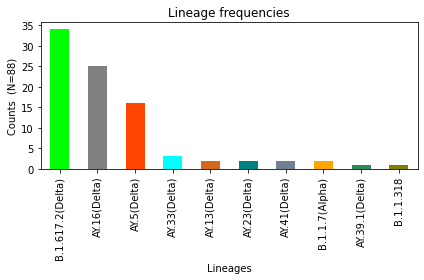

In [95]:
import math
# plot lineage frequencies
width = lins.sort_values(ascending=False)

colors = [lin_clrs[lin.split('(')[0]] for lin in list(width.index)]
n = df_report_fnl['Pango Lineage Annotation'].count()
yticks = np.arange(0, (math.ceil(max_count / 5) + 1) * 5, 5)
fig, ax = plt.subplots()
# (df_report_fnl['Pango Lineage Annotation']
#  .value_counts().
width.plot(kind='bar', ax=ax, color=colors)
plt.title('Lineage frequencies')
plt.xlabel('Lineages')
plt.yticks(yticks)
plt.xticks(ticks=range(len(lins)), rotation=90, labels=width.index)
plt.ylabel(f'Counts  (N={n})')
plt.tight_layout()
# fig.savefig('/home/douso/SarsGenomics/Processed/policy-brief-P-ONT.png')
plt.show()

In [96]:
row_order = df_report_fnl.groupby('Sample County of Origin').count()[['Sequence Name']].sort_values('Sequence Name', ascending=False).index

In [97]:
df_report_fnl['Sample County of Origin'] = pd.Categorical(df_report_fnl['Sample County of Origin'], categories=row_order,ordered=True)

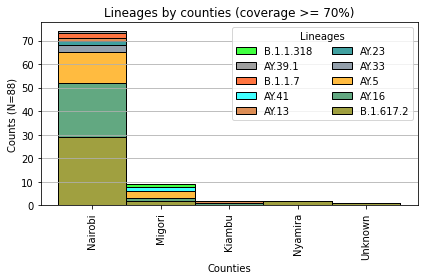

In [98]:
df_seq_summ10Ls_srt = df_report_fnl.rename(columns={'Pango Lineage Annotation':'Lineages'})#.sort_values('Sample County of Origin', ascending=False)
fig,ax = plt.subplots(figsize=(6,4))
# sns.set_palette(sns.color_palette(colors.values()))
palette_clr = colors# {l: colors[l] for l in df_seq_summ10Ls_srt.Lineages.unique()}
# sns.set_color_codes('pastel')
sns.histplot(df_seq_summ10Ls_srt, x='Sample County of Origin', 
            hue='Lineages',multiple="stack",
             hue_order=reversed(df_report_fnl['Pango Lineage Annotation'].value_counts().index),
           palette=palette_clr, ax=ax, legend=True)#legend=True, loc='upper right',title='Lineages', ncol=1, borderaxespad=0
# ax.get_legend()
l = ax.get_legend()
h = l.legendHandles
plt.xticks(rotation=90)
plt.ylabel(f'Counts (N={df_seq_summ10Ls_srt.shape[0]})')
plt.xlabel('Counties')
# l.remove()
plt.legend(h, [t.get_text() for t in l.texts], title='Lineages', fancybox=True, ncol=2)#, loc=(1.01, 0.03)labelspacing=0.25, 
# plt.legend(df_seq_summ10Ls_srt.LIN.value_counts().sort_values(ascending=True)[-10:].index,
#           title='Lineages', ncol=1)#, bbox_to_anchor=(1,1)
plt.title('Lineages by counties (coverage >= 70%)', fontsize=12)
plt.grid(axis='y')
plt.tight_layout()
# plt.savefig(f"{glob.glob(f'{parent_dir}/**/KnowledgeBrief', recursive=True)[0]}/policy-linXcounty{category+'_'}{dt}.{ext}")
plt.show()